Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [1]:

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error

Data Acquisition

In [2]:
df = pd.read_csv("preprocessed_dataset.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

attributes = list(df.columns)
data = df.values

Function for splitting the dataset into sequences of observations of length history size.

In [4]:
def sequencing(dataset, start_index=0, end_index=None, history_size=30, step=1, lag=0):
    # lag=1 means 2 ahead predictions (like in RNN/LSTM code)

    data = []
    start_index = start_index + history_size + 1 + lag
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size - 1 - lag, i, step)
        data.append(dataset[indices])
    return np.array(data)


Function for splitting the dataset into training, validation and testing, and data normalization.

In [5]:
def partition(data, pTrain=0.8, pVal = 0.5, save_path=None, history_size=30, lag=0):
    data_mean = data[:int(pTrain*len(data))].mean(axis=0)
    data_std = data[:int(pTrain*len(data))].std(axis=0)

    data = (data - data_mean)/data_std
    stats = np.array([data_mean, data_std])

    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=history_size, step=1, lag=lag)

    dataTrain = sequencedData[:int(sequencedData.shape[0]*pTrain), :, :]
    dataVal = sequencedData[int(sequencedData.shape[0]*pTrain):int(sequencedData.shape[0]*(pTrain+(1-pTrain)*pVal)), :, :]
    dataTest = sequencedData[int(sequencedData.shape[0]*(pTrain+(1-pTrain)*pVal)):, :, :]

    return dataTrain, dataVal, dataTest, stats

Create input-output pairs.

In [6]:
def split(chunk,lag):
    inputs = torch.tensor(chunk[:, :-lag-1, :], device=device)
    targets = torch.tensor(chunk[:, lag+1:, :], device=device)
    return inputs, targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [7]:
def createLoaders(dataTrain, dataVal, dataTest, batchSize=32, responseVariables=[1], lag=0):
    XTrain, YTrain = split(dataTrain, lag)
    XVal, YVal = split(dataVal, lag)
    XTest, YTest = split(dataTest, lag)

    YTrain = YTrain[:,:,responseVariables]
    YVal = YVal[:,:,responseVariables]
    YTest = YTest[:,:,responseVariables]

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader


Transformer NN implementation

In [8]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [9]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=30, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps.
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1).double()
    return mask  # (size, size)

# create_look_ahead_mask(6)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):

        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)

        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [10]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate, history):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D, position=history)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim,
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.double()

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = self.output_projection(x)

        return x, attention_weights # (B,S,S)

Metrics with different hyperparameter values

In [ ]:
#%pip install -q evaluate
import itertools
import numpy as np
from evaluate import load
#!pip3 install tqdm
from tqdm import tqdm

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

batch = 7*2*12
history = 4*12
trainData, valData, testData, stats = partition(data,pTrain=0.85,history_size=history,lag=0)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData, batchSize=batch, lag=0)

# Here we just de-sequence the sequenced training data
trainTarget = [target[-1, :] for target in trainData]
trainTarget = np.array(trainTarget)
trainTarget

num_layers_list, lr_list, H_list, mase_list, smape_list, validation_predictions_list = [],[],[],[],[],[]

combinations = list(itertools.product([1, 2, 3], [0.00005, 0.0001, 0.0005], [4, 8, 16]))

for combination in combinations:

    transformer = Transformer(num_layers=combination[0], D=32, H=combination[2], hidden_mlp_dim=32,
                                inp_features=4, out_features=1, dropout_rate=0.1, history=history).to(device)
    optimizer = torch.optim.RMSprop(transformer.parameters(),
                                    lr=combination[1])

    # Training

    n_epochs = 25
    niter = len(trainDataset)
    losses = []

    for e in tqdm(range(n_epochs)):

        # one epoch on train set
        transformer.train()
        sum_train_loss = 0.0
        for x,y in trainDataset:
            S = x.shape[1]
            mask = create_look_ahead_mask(S)
            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out, y)
            sum_train_loss += loss.item()
            loss.backward()
            optimizer.step()
        losses.append(sum_train_loss / niter)

    # Here we just de-sequence the sequenced validation data
    valTarget = [target[-1, :] for target in valData]
    valTarget = np.array(valTarget)

    # Validation

    transformer.eval()

    # Here we get the first sequence from the validation dataset - so first days from val data to predict from
    it = iter(valDataset)
    (inputs, targets) = next(it)
    last_x = torch.unsqueeze(inputs[0], 0)  # unsqueeze because of the NN wants it this way, from [[1...5]..[1...5]] to [[[1...5]..[1...5]]]
    validation_predictions = []

    # While we do not have enough days predicted, we continue
    count = 1
    while len(validation_predictions) < len(valTarget):
        S = last_x.shape[1]
        mask = create_look_ahead_mask(S)
        # Predict
        p, attn = transformer(x=last_x, mask=mask)
        # Add the new predicted values for one day to the prediction list
        validation_predictions.append(p[0, -1, :].detach().cpu().numpy()[0])
        # Roll to predict new day in next iteration
        last_x = torch.roll(last_x, -1, dims=1)

        try:
          next_x = torch.unsqueeze(inputs[count], 0)
        except IndexError:
          try:
              (inputs, targets) = next(it)
          except:
              break
          count = 0
          next_x = torch.unsqueeze(inputs[count], 0)

        # Add actual values of other variables + predicted value to the values we predict from next
        new_values = next_x[:,-1,:]
        new_values[:,1] = p[0, -1, :]

        last_x[:,-1,:] = new_values
        count += 1

    # Calculate metrics

    validation_predictions_plot = np.array(validation_predictions)*stats[1,1] + stats[0,1]
    valTarget = np.array(valTarget)*stats[1,1] + stats[0,1]

    mase_training = np.array(trainTarget)*stats[1,1] + stats[0,1]
    mase_training = mase_training[:, 1]
    mase_result = mase_metric.compute(references=valTarget[:,1], predictions=validation_predictions_plot, training=mase_training)
    smape_result = smape_metric.compute(references=valTarget[:,1], predictions=validation_predictions_plot)

    print(f'MASE: {mase_result}')
    print(f'SMAPE: {smape_result}')

    num_layers_list.append(combination[0])
    lr_list.append(combination[1])
    H_list.append(combination[2])
    mase_list.append(mase_result)
    smape_list.append(smape_result)
    validation_predictions_list.append(validation_predictions_plot)

dict = {'num_layers': num_layers_list, 'lr': lr_list, 'H': H_list, 'MASE': mase_list, 'SMAPE': smape_list}
df_results = pd.DataFrame(dict)

df_results.to_csv('hyperparameter_results_transformer.csv')

Testing with test partition

In [12]:
# Get the best hyperparameter values

df_results = pd.read_csv('hyperparameter_results_transformer.csv')
mase_list = df_results['MASE'].tolist()
mase_list = np.array([float(value.split(' ')[len(value.split(' ')) -1 ].split('}')[0]) for value in mase_list])

opt = [df_results.loc[np.argmin(mase_list),'num_layers'], df_results.loc[np.argmin(mase_list),'lr'], df_results.loc[np.argmin(mase_list),'H']]
print(opt)

transformer = Transformer(num_layers=opt[0], D=32, H=opt[2], hidden_mlp_dim=32,
                            inp_features=4, out_features=1, dropout_rate=0.1, history=history).to(device)
optimizer = (torch.
             optim.RMSprop(transformer.parameters(),
                                lr=opt[1]))

# Put de-sequenced training and validation data together
trainValTarget = np.concatenate((trainTarget, valTarget), axis=0)

# Training with training and validation sets

n_epochs = 25
niter = len(trainDataset) + len(valDataset)
losses = []

start = time.time()
for e in tqdm(range(n_epochs)):

    transformer.train()
    sum_train_loss = 0.0
    for x,y in trainDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    for x,y in valDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    losses.append(sum_train_loss / niter)
end = time.time()
print("Training time: " + str(end - start))

# Here we just de-sequence the sequenced test data
testTarget = [target[-1, :] for target in testData]
testTarget = np.array(testTarget)
testTarget

# Testing

transformer.eval()

# Here we get the first sequence from the test dataset - so first days from test data to predict from
it = iter(testDataset)
(inputs, targets) = next(it)
last_x = torch.unsqueeze(inputs[0], 0)  # unsqueeze because of the NN wants it this way, from [[1...5]..[1...5]] to [[[1...5]..[1...5]]]
test_predictions = []

# While we do not have enough days predicted, we continue
count = 1
while len(test_predictions) < len(testTarget):
    S = last_x.shape[1]
    mask = create_look_ahead_mask(S)
    # Predict
    p, attn = transformer(x=last_x, mask=mask)
    # Add the new predicted values for one day to the prediction list
    test_predictions.append(p[0, -1, :].detach().cpu().numpy()[0])
    # Roll to predict new day in next iteration
    last_x = torch.roll(last_x, -1, dims=1)

    try:
      next_x = torch.unsqueeze(inputs[count], 0)
    except IndexError:
      try:
          (inputs, targets) = next(it)
      except:
          break
      count = 0
      next_x = torch.unsqueeze(inputs[count], 0)

    # Add actual values of other variables + predicted value to the values we predict from next
    new_values = next_x[:,-1,:]
    new_values[:,1] = p[0, -1, :]

    last_x[:,-1,:] = new_values
    count += 1


[1, 5e-05, 4]


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Training time: 3.572578191757202


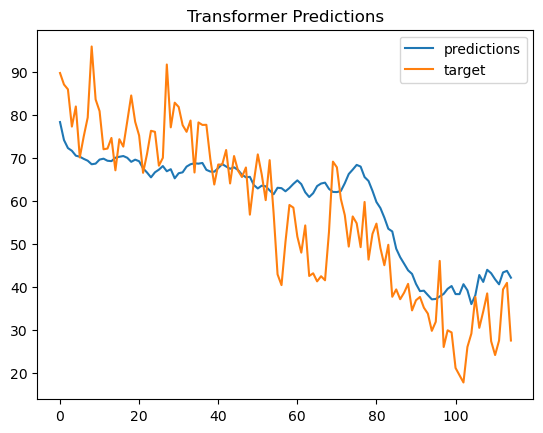

In [13]:
test_predictions_plot = np.array(test_predictions)*stats[1,1] + stats[0,1]
testTarget = np.array(testTarget)*stats[1,1] + stats[0,1]

plt.plot(test_predictions_plot, label="predictions")
plt.plot(testTarget[:, 1], label="target")
plt.title("Transformer Predictions")
plt.legend()
plt.show()

In [14]:

mase_training = np.array(trainValTarget)*stats[1,1] + stats[0,1]
mase_training = mase_training[:, 1]
mase_result = mase_metric.compute(references=testTarget[:,1], predictions=test_predictions_plot, training=mase_training)
smape_result = smape_metric.compute(references=testTarget[:,1], predictions=test_predictions_plot)

print(f'MASE: {mase_result}')
print(f'SMAPE: {smape_result}')

mase_forecast_power = [mase_result]
smape_forecast_power = [smape_result]
mse_forecast_power = [mean_squared_error(testTarget[:,1], test_predictions_plot)]

for i in range(1,len(test_predictions_plot)):
    mase_forecast_power.append(mase_metric.compute(references=testTarget[:-i,1], predictions=test_predictions_plot[:-i], training=mase_training))
    smape_forecast_power.append(smape_metric.compute(references=testTarget[:-i,1], predictions=test_predictions_plot[:-i]))
    mse_forecast_power.append(mean_squared_error(testTarget[:-i,1], test_predictions_plot[:-i]))

df_dict = {'tnn_mase_forecast_power': mase_forecast_power[::-1], 'tnn_smape_forecast_power': smape_forecast_power[::-1], 'tnn_mse_forecast_power': mse_forecast_power[::-1]}
df_results = pd.DataFrame(df_dict)

df_results.to_csv('forecast_power_tnn.csv')

MASE: {'mase': 0.6852957176922095}
SMAPE: {'smape': 0.17554129075185837}
